## Problem Statement - 
#### Develop a Transformer model from scratch for sentiment prediction on the Amazon Fine Food Reviews dataset.

#### About the Dataset: Amazon Fine Food Reviews dataset

Amazon Fine Food Reviews (~500,000 food reviews from Amazon) is developed by the Stanford Network Analysis Project. This dataset consists of fine food reviews from Amazon, spanning over 10 years and including all ~500,000 reviews up to October 2012. The reviews contain product and user information, ratings, and plain text feedback. It also includes reviews from various other Amazon categories.
Dataset Summary:
- Reviews from October 1999 - October 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with more than 50 reviews

You can get it from Kaggle - https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

**The models were implemented using the Python programming language, specifically Python version 3.12.3, on hardware with the following configurations: Operating System Windows 11, Intel® Core™ i3-1035G1 CPU @ 1.00GHz processor, and 8.00 GB of installed physical memory (RAM).**

**I will be making a Encoder-only Transformer model (inspired by the BERT-style models rather than full Transformer architectures like GPT or Seq2Seq Transformers which have both Encoder and Decoder layers), as the task does not require a Decoder (The Decoder is mainly used for sequence generation tasks like machine translation, text summarization, or chatbot responses and the computations involved might get too complex for a low end device to handle!)**

#### Installing Libraries

In [ ]:
!pip install pandas numpy tensorflow scikit-learn

#### Importing Libraries and necessary modules

In [1]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

#### Ignoring the warnings (Optional)

In [55]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.disable_resource_variables()

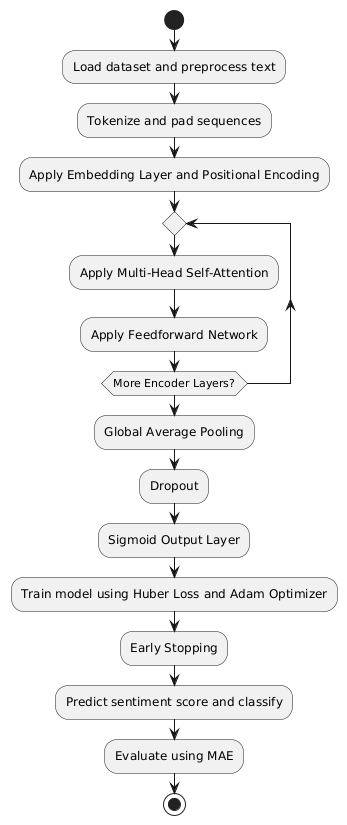

####  Fig: Flowchart for the model 

#### Read the dataset

In [3]:
df = pd.read_csv("Reviews.csv")

In [4]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [5]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


### Data Preprocessing and Exploratory Data Analysis

In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
df.shape

(568454, 10)

In [8]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

**Based on the dataset, We can observe that the missing values are independent of other variables, so, we cannot use imputation techniques here. We can easily remove the null values and carry forward the preprocessing steps!** 

In [9]:
df = df.dropna(subset=['Text', 'Score','Summary','ProfileName'])  

In [10]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [11]:
df.shape

(568401, 10)

**It seems only the 'Text' and 'Score' columns are the only important columns in this dataset for the task, so, removing other columns**

In [12]:
df = df[['Text', 'Score']]

In [13]:
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


#### Cleaning the Text

In [14]:
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters & punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

#### Normalizing the Score column (between 1 and 5) to a 0-1 range.

In [15]:
df['Cleaned_Text'] = df['Text'].apply(clean_text)
df['Score'] = (df['Score'] - 1) / 4

In [16]:
score_counts = df['Score'].value_counts().sort_index()

for score, count in score_counts.items():
    print(f"Score {int(score * 4 + 1)}: {count} samples")

Score 1: 52264 samples
Score 2: 29743 samples
Score 3: 42638 samples
Score 4: 80654 samples
Score 5: 363102 samples


**This dataset is highly imbalanced!! The sample texts having score '4' & '5' are way more than the sample texts having lesser scores. It can lead to biased prediction!! Lets try Resampling method to decrease the number of samples of higher scores.**

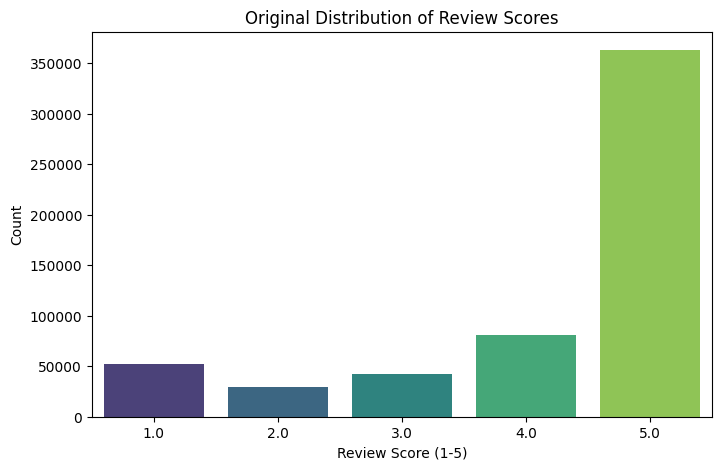

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(x=score_counts.index * 4 + 1, y=score_counts.values, palette="viridis")
plt.xlabel("Review Score (1-5)")
plt.ylabel("Count")
plt.title("Original Distribution of Review Scores")
plt.show()

#### Fig: Original Distribution of Review Scores

## Problem!!

#### 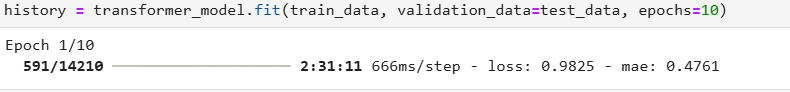
**Processing the full dataset (over 5 lakh samples) requires extensive computational resources and a high-end device. So, only a subset (30% of the dataset) is used for computations.**

In [18]:
df = df.sample(frac=0.3, random_state=42)

**Now, calculating the number of samples for each score.**

In [19]:
score_counts = df['Score'].value_counts().sort_index()

for score, count in score_counts.items():
    print(f"Score {int(score * 4 + 1)}: {count} samples")

Score 1: 15518 samples
Score 2: 8848 samples
Score 3: 12835 samples
Score 4: 24131 samples
Score 5: 109188 samples


**The number of samples with a score of 5 is still significantly high, which may lead to bias in the model after training. We need to implement a strategy to mitigate this imbalance and ensure the dataset remains unbiased.**

## Another Problem into consideration!!
##### So, in the first phase (initial phase) of making this model, I thought of resampling the dataset by using mean of other scores (1 to 4), and taking only those number of samples of score = 5, which would be like this 
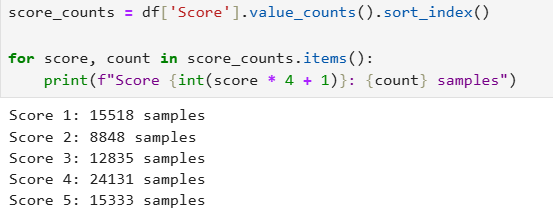

##### However, this approach introduced a new challenge: **Score = 4 also had a disproportionately high number of samples**, which could still lead to bias in the model. To address this, I adopted a **proportional resampling strategy** based on the natural distribution of scores:  

- **Score = 5** had the **highest number of samples** 📈  
- **Score = 4** was also **relatively high**, though lower than Score = 5  
- **Scores 1 to 3** had **moderate to low sample counts**   

To maintain **relative balance** while reducing bias, I used the **mean count of Scores 1 to 3** (`mean_other_scores`) as a **baseline** and applied **scaling factors** 📏 to adjust the number of samples for Scores 4 and 5:  

**Score = 5 → Resampled to** `mean_other_scores * 1.5` (slightly higher than the mean)  
**Score = 4 → Resampled to** `mean_other_scores * 1.2` (higher than the mean but lower than Score = 5)  

---

In [20]:
mean_other_scores = int(np.mean(score_counts[score_counts.index < 0.75]))  

score_5_target = int(mean_other_scores * 1.5)  # Score = 5 (1.0 after normalization)
score_4_target = int(mean_other_scores * 1.2)  # Score = 4 (0.75 after normalization)

df_score_5 = df[np.isclose(df['Score'], 1.0)]
df_score_4 = df[np.isclose(df['Score'], 0.75)]
df_other_scores = df[df['Score'] < 0.75]  # Scores 1, 2, 3

df_score_5_reduced = resample(df_score_5, replace=False, n_samples=min(len(df_score_5), score_5_target), random_state=42)
df_score_4_reduced = resample(df_score_4, replace=False, n_samples=min(len(df_score_4), score_4_target), random_state=42)

df = pd.concat([df_score_5_reduced, df_score_4_reduced, df_other_scores]).sample(frac=1, random_state=42)

print(df['Score'].value_counts().sort_index())

Score
0.00    15518
0.25     8848
0.50    12835
0.75    14880
1.00    18600
Name: count, dtype: int64


In [21]:
score_counts = df['Score'].value_counts().sort_index()

for score, count in score_counts.items():
    print(f"Score {int(score * 4 + 1)}: {count} samples")

Score 1: 15518 samples
Score 2: 8848 samples
Score 3: 12835 samples
Score 4: 14880 samples
Score 5: 18600 samples


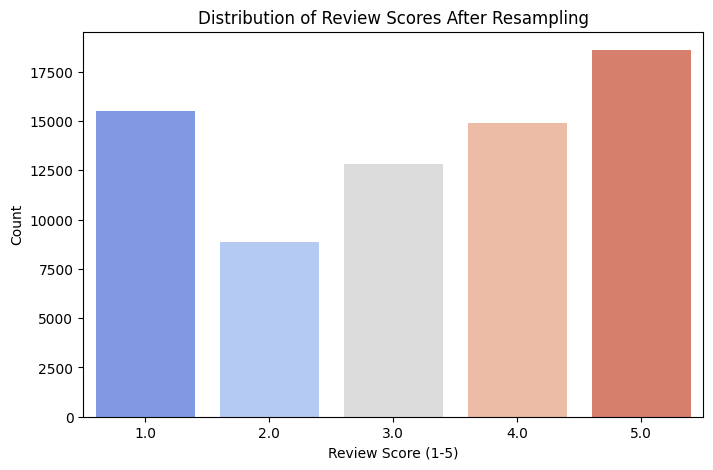

In [22]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['Score'].value_counts().sort_index().index * 4 + 1, 
            y=df['Score'].value_counts().sort_index().values, 
            palette="coolwarm")
plt.xlabel("Review Score (1-5)")
plt.ylabel("Count")
plt.title("Distribution of Review Scores After Resampling")
plt.show()

#### Fig: Distribution of Review Scores After Resampling

**Let's move forward in finding out the distribution of review lengths to analyze the count of different review lengths**

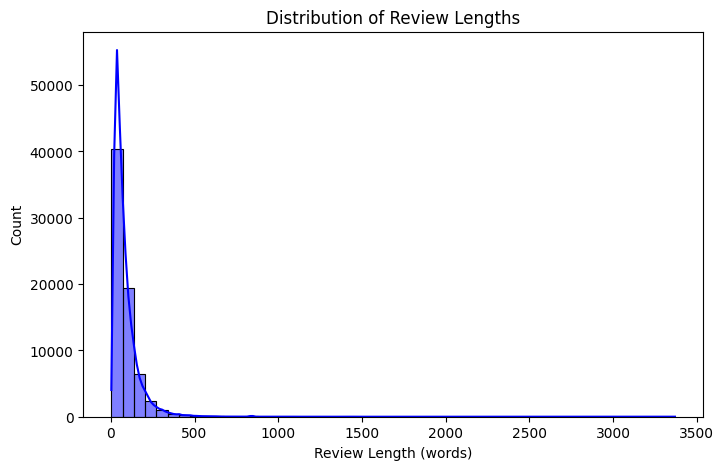

In [23]:
review_lengths = df['Cleaned_Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(review_lengths, bins=50, kde=True, color="blue")
plt.xlabel("Review Length (words)")
plt.ylabel("Count")
plt.title("Distribution of Review Lengths")
plt.show()

**We can observe in the plot that it is a Right-Skewed distribution**
##### - Most reviews are short, concentrated under 100 words.
##### - A few reviews are very long, stretching beyond 1000+ words.
##### - Majority of Reviews are Short
##### - The highest peak (mode) is at low word counts (between 0–100 words). This suggests that most reviews are concise rather than lengthy.
##### - Some reviews are exceptionally long (above 2000 words).

In [24]:
review_lengths = df['Cleaned_Text'].apply(lambda x: len(x.split()))
max_length = int(np.percentile(review_lengths, 95))

print("Recommended max_length:", max_length)

Recommended max_length: 224


**What is Max Length → The threshold we set for the maximum number of words a review can have.**

---
**Why specifically 95th percentile?**
- Because it is a balanced approach.
- Retains Most Data (95%)
- Reduces Computational Overhead
- Many NLP tasks use the 95th percentile to balance efficiency vs. completeness. Example: BERT, GPT-based models often truncate sequences around 512 tokens based on similar principles.

**Alternative Percentiles?**
- 90th Percentile → More aggressive truncation (removes 10% longest reviews).
- 99th Percentile → Less truncation but adds more padding overhead.
- 100th Percentile → No truncation, but wastes memory & slows training.
Bottom Line: 95% - captures most of the data without excessive computational cost... 

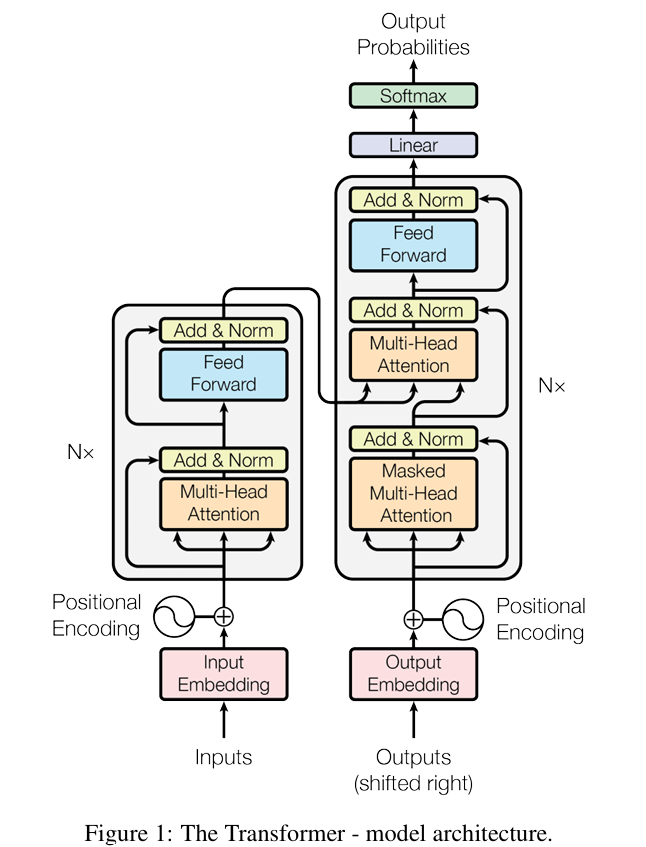

**The above model architecture is derived from the highly influential research paper *"Attention is All You Need,"* authored by Vaswani et al. This paper introduced the Transformer model, which revolutionized natural language processing by replacing recurrent and convolutional networks with a self-attention mechanism.**

#### You can get it from - https://arxiv.org/pdf/1706.03762

| Feature            | Transformer 🚀 | RNN 🔄 | LSTM 🔁 | CNN (for NLP) 📸 |
|--------------------|--------------|--------|--------|------------------|
| **Processing Type**  | Parallel ⚡ | Sequential 🐢 | Sequential 🐢 | Local Context Only 🔍 |
| **Speed**         | Fast 🚀 | Slow 🐌 | Slower 🐌 | Faster than RNN ⚡ |
| **Long-Range Dependencies** | Excellent ✅ | Weak ❌ | Better ✅ | Limited ❌ |
| **Memory Usage**  | High 📈 | Low 📉 | Medium 🔄 | Medium 🔄 |
| **Training Complexity** | High 🔥 | Low 🟢 | Medium 🔄 | Medium 🔄 |
| **Scalability**   | High ✅ | Low ❌ | Medium ⚖️ | High ✅ |
| **Applications**  | NLP, Vision, Speech 🧠 | Text Data 📜 | Text Data 📜 | NLP, Image Processing 🖼️ |
| **Works Well With Small Data?** | No ❌ | Yes ✅ | Yes ✅ | Yes ✅ |


In [25]:
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Cleaned_Text'])

word_counts = Counter(tokenizer.word_counts)
total_words = len(word_counts)

print("Total unique words in dataset:", total_words)

Total unique words in dataset: 98992


In [26]:
vocab_size = min(20000, len(word_counts))
vocab_size

20000

#### Tokenization (Converting Words to Vectors(Numbers))

In [27]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned_Text'])

#### Padding (Making Sequences of Equal Length by adding extra 0's at the end if sequence_length < max_length) and truncating(Making Sequences of Equal Length by removing extra words from the end if sequence_length > max_length)

In [28]:
sequences = tokenizer.texts_to_sequences(df['Cleaned_Text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

### **For understanding**

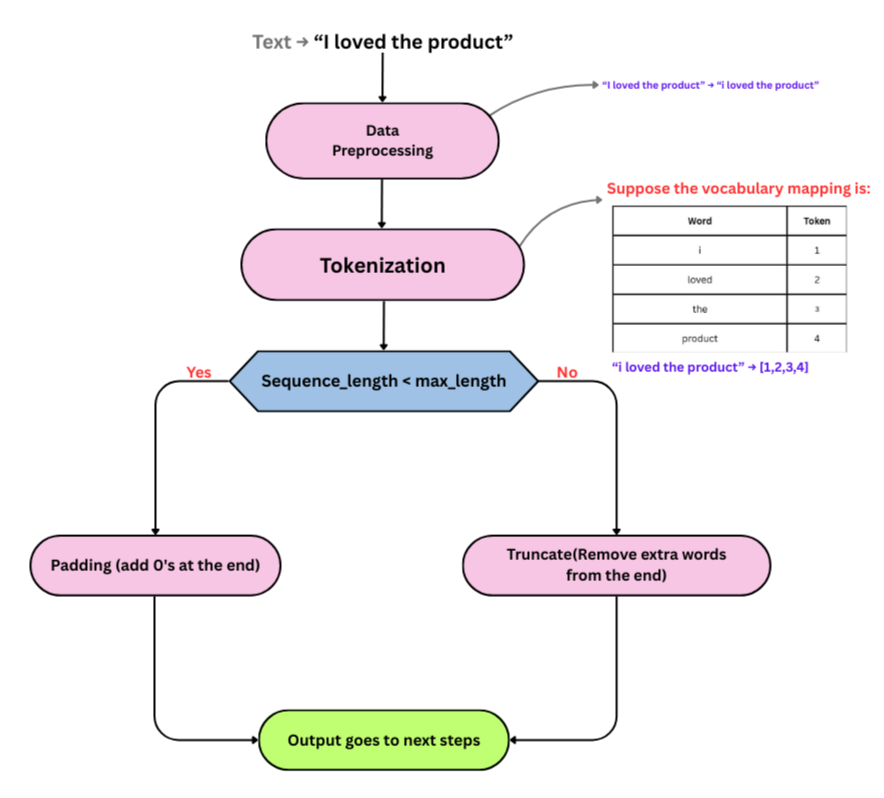

#### Get the above diagram in .pdf - https://drive.google.com/file/d/1w-CFAj7c2Nl9A9zmX0CvN--xM-tnraQg/view?usp=sharing

#### Train-Test Split (80% for Training and 20% for Testing)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Score'], test_size=0.2, random_state=42)
batch_size = 128
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

#### Transformer Parts

In [30]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(
            10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.convert_to_tensor(angle_rads[np.newaxis, ...], dtype=tf.float32)

    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [31]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.depth = embed_dim // num_heads
        self.wq = Dense(embed_dim)
        self.wk = Dense(embed_dim)
        self.wv = Dense(embed_dim)
        self.dense = Dense(embed_dim)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs, mask=None, training=False):
        batch_size = tf.shape(inputs)[0]
        q = self.split_heads(self.wq(inputs), batch_size)
        k = self.split_heads(self.wk(inputs), batch_size)
        v = self.split_heads(self.wv(inputs), batch_size)
        attn_weights = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(self.depth, tf.float32)), axis=-1)
        output = tf.matmul(attn_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(output, (batch_size, -1, self.num_heads * self.depth))
        return self.dense(concat_output)

In [32]:
def build_transformer_model(embed_dim=64, num_heads=4, ff_dim=256, num_layers=6):
    inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(vocab_size, embed_dim)(inputs)
    x = PositionalEncoding(max_length, embed_dim)(embedding_layer)
    
    for _ in range(num_layers):
        x = TransformerEncoderLayer(embed_dim, num_heads, ff_dim)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1, activation='sigmoid')(x)  
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [33]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

#### Learning rate

In [57]:
lr = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)

#### Building and Compiling the Transformer Model

In [58]:
transformer_model = build_transformer_model()
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                          loss=tf.keras.losses.Huber(), 
                          metrics=['mae'])

#### Early Stopping

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Problem Faced!!
---
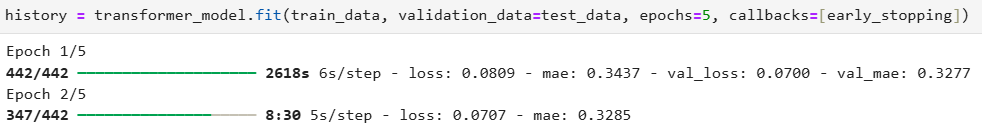

---
**Almost 45 minutes per epoch if**
- 6 transformer layers
- 8 attention heads
- Feed forward Network(FFN) layer has 512 units
- embedding layer dimension is 128
- 5 Epochs
- batch_size is 128
- Early Stopping (patience = 5)

**So, for the sake of completing the project and gather the outputs, I have changed these parameters in order to reduce computations.(However, this might increase the error.)**

- Initially: 

def build_transformer_model(embed_dim=128, num_heads=8, ff_dim=512, num_layers=6)

- Changed to: 

def build_transformer_model(embed_dim=64, num_heads=4, ff_dim=256, num_layers=6)

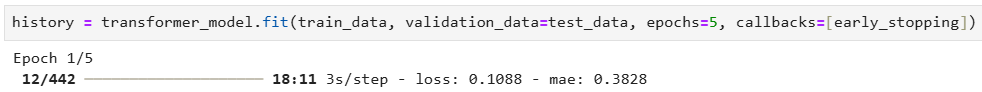

**Hence, computation time is reduced to atmost 17 minutes per epoch!!**

#### Training the model

In [37]:
history = transformer_model.fit(train_data, validation_data=test_data, epochs=5, callbacks=[early_stopping])

Epoch 1/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 1070s 2s/step - loss: 0.0750 - mae: 0.3355 - val_loss: 0.0697 - val_mae: 0.3258
Epoch 2/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - loss: 0.0704 - mae: 0.3282 - val_loss: 0.0698 - val_mae: 0.3255
Epoch 3/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - loss: 0.0703 - mae: 0.3280 - val_loss: 0.0690 - val_mae: 0.3234
Epoch 4/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 1723s 4s/step - loss: 0.0562 - mae: 0.2812 - val_loss: 0.0328 - val_mae: 0.1974
Epoch 5/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 1003s 2s/step - loss: 0.0298 - mae: 0.1931 - val_loss: 0.0297 - val_mae: 0.1873


#### Testing the model

In [38]:
test_loss, test_mae = transformer_model.evaluate(test_data)
print(f"Test MAE: {test_mae:.4f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 742ms/step - loss: 0.0284 - mae: 0.1834
Test MAE: 0.1873


#### Prediction from Raw Texts Input

In [50]:
def predict_sentiment(text):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    prediction = transformer_model.predict(padded_sequence)[0][0]  
    sentiment_score = prediction * 4 + 1  
    sentiment_score = max(1, min(5, sentiment_score))
    
    print(f"Sentiment Score: {sentiment_score}")

In [51]:
predict_sentiment("This product is good")
predict_sentiment("Bad product!! Not as described")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Sentiment Score: 4.688973426818848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Sentiment Score: 1.395344316959381


In [52]:
predict_sentiment("Worst product ever")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Sentiment Score: 1.169407606124878


In [53]:
predict_sentiment("Delight says it all")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Sentiment Score: 3.5301051139831543


---

### End of Project

---

- My github: https://github.com/Handa1810
- My LinkedIn: www.linkedin.com/in/yashhanda18
- Handwritten notes for Transformers: https://drive.google.com/file/d/1vubb8LeprtrjxFLBeX7sJ7_RrDZjA_g5/view?usp=sharing